# Olist E-commerce Customer Satisfaction Prediction Project

## Introduction
This project focuses on analyzing and predicting customer satisfaction for Olist, one of Brazil's largest e-commerce platforms. By leveraging machine learning techniques and comprehensive data analysis, we aim to develop a predictive model that can identify potential customer satisfaction issues before they materialize into negative reviews.

## Project Scope
The analysis centers on the review_score metric as our target variable, utilizing Olist's rich dataset that encompasses order details, customer information, product characteristics, and seller performance metrics. Our goal is to create a binary classification model that can effectively predict whether a customer will provide a high satisfaction rating (>=4) or not.

## Project Roadmap

### 1. Data Understanding and Preparation
- Database schema analysis and relationship mapping
- Feature identification and initial data quality assessment
- Handling missing values and outliers
- Data integration from multiple Olist tables

### 2. Exploratory Data Analysis (EDA)
- Quantitative analysis of review scores distribution
- Temporal patterns in customer satisfaction
- Correlation analysis between various features and satisfaction levels
- Product category impact on customer satisfaction

### 3. Feature Engineering
- Creation of delivery performance metrics
- Price and freight relationship features
- Temporal features extraction

### 4. Model Development
- Data preprocessing and scaling
- Implementation of various ML algorithms:
  - Random Forest
  - XGBoost
  - LightGBM
  - CatBoost
- Hyperparameter optimization using BayesSearchCV
- Model performance comparison and selection

### 5. Evaluation and Insights
- Model performance metrics analysis
- Feature importance interpretation
- Business insights extraction
- Actionable recommendations development

## Expected Outcomes
1. A robust predictive model for customer satisfaction
2. Identification of key factors influencing customer ratings
3. Actionable insights for improving customer experience
4. Early warning system for potential customer dissatisfaction
5. Recommendations for operational improvements

## Business Value
This project aims to provide Olist with:
- Proactive customer satisfaction management
- Reduced negative reviews through early intervention
- Improved operational efficiency
- Data-driven decision-making capabilities

## Technical Stack
- Python for data analysis and modeling
- Pandas & NumPy for data manipulation
- Scikit-learn for machine learning implementation
- Advanced ML libraries (XGBoost, LightGBM, CatBoost)
- Data visualization libraries (Matplotlib, Seaborn)

This comprehensive analysis will serve as a foundation for implementing data-driven strategies to enhance customer satisfaction and overall business performance.


In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data acquisition and database connection
import kagglehub
import os

# Statistical analysis
from scipy import stats

# Machine Learning models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ML preprocessing and optimization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# ML metrics and evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.makedirs('output', exist_ok=True)

In [ ]:
# Download do dataset
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")  # Downloads the Brazilian e-commerce dataset from Kaggle


files = os.listdir(path)  # Gets list of all files in the downloaded dataset directory

# Creates a dictionary to store all dataframes
olist_data = {}
for file in files:
    file_path = os.path.join(path, file)  # Constructs full file path
    df_name = file.split('.')[0]  # Extracts filename without extension to use as dictionary key
    olist_data[df_name] = pd.read_csv(file_path)  # Reads CSV file into pandas DataFrame and stores in dictionary

# Prints names of all available tables
list_data = list(olist_data.keys())  # Gets list of all table names
for i in list_data:
    print(f'Tabela de nome = {i}')  # Prints each table name

Tabela de nome = olist_customers_dataset
Tabela de nome = olist_geolocation_dataset
Tabela de nome = olist_orders_dataset
Tabela de nome = olist_order_items_dataset
Tabela de nome = olist_order_payments_dataset
Tabela de nome = olist_order_reviews_dataset
Tabela de nome = olist_products_dataset
Tabela de nome = olist_sellers_dataset
Tabela de nome = product_category_name_translation


In [4]:
def data_info(df):
    """
    Creates a summary DataFrame containing information about each column in the input DataFrame.
    
    Parameters:
        df (pandas.DataFrame): Input DataFrame to analyze
        
    Returns:
        pandas.DataFrame: A DataFrame with the following columns:
            - dtypes: Data type of each column
            - Missing: Number of missing values in each column
            - Unique: Number of unique values in each column
            - Example: First value from each column
            - Entropy: Shannon entropy of value distributions (in bits)
            
    Notes:
        - Prints the shape of the input DataFrame
        - Entropy is calculated using scipy.stats.entropy with base 2
        - Higher entropy values indicate more uniform distributions
    """
    info = pd.DataFrame({
        'dtypes': df.dtypes,
        'Missing': df.isna().sum(),
        'Unique': df.nunique(),
        'Example': df.iloc[0],
        'Entropy': [round(stats.entropy(df[col].value_counts(normalize=True), base=2), 2) 
                   for col in df.columns]
    })
    
    print(f"Dataset Shape: {df.shape}")
    return info

In [5]:

df = olist_data['olist_orders_dataset'].merge(olist_data['olist_order_reviews_dataset'], on='order_id')\
                   .merge(olist_data['olist_order_payments_dataset'], on='order_id')\
                   .merge(olist_data['olist_customers_dataset'], on='customer_id')\
                   .merge(olist_data['olist_order_items_dataset'], on='order_id')\
                   .merge(olist_data['olist_products_dataset'], on='product_id')\
                   .merge(olist_data['olist_sellers_dataset'], on='seller_id')

print(f'Duplicated rows: {df.duplicated().sum()}')
data_info(df)

Duplicated rows: 0
Dataset Shape: (117329, 39)


,dtypes,Missing,Unique,Example,Entropy
order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
order_status,object,0,7,delivered,0.19
order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42
order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26
order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02
order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39
order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47
review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
review_score,int64,0,5,4,1.77


## Feature Engineering

### Temporal Analysis

In this code section, we perform feature engineering focused on temporal aspects of orders. The transformations can be divided into two main groups:

### 1. Time Components
We extract different components from the purchase date (`order_purchase_timestamp`):
- `purchase_year_month`: Complete period (year-month) for monthly analysis
- `purchase_year`: Purchase year
- `purchase_month`: Purchase month
- `purchase_day`: Purchase day

### 2. Time Metrics (Deltas)
We calculate the differences in days between important order events:
- `delta_approved`: Time between purchase and approval
- `delta_estimated_delivery`: Estimated delivery time
- `delta_shipping_limit`: Shipping deadline
- `delta_delivered_customer`: Actual delivery time to customer
- `delta_delivered_carrier`: Delivery time to carrier

These features are important for:
- Seasonality analysis
- Process bottleneck identification
- Logistics efficiency evaluation
- Delivery delay prediction

In [6]:
datetime_columns = ['order_purchase_timestamp', 
                    'order_approved_at', 
                    'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 
                    'review_answer_timestamp',
                    'shipping_limit_date']

# Convert to datetime and keep only the date part (YYYY-MM-DD)
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col]).dt.normalize()

df[datetime_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
shipping_limit_date              datetime64[ns]
dtype: object

In [7]:
# Extracting time components from purchase date
df['purchase_year_month'] = df['order_purchase_timestamp'].dt.to_period('M')  # Year-month period
df['purchase_year'] = df['order_purchase_timestamp'].dt.year                  # Purchase year
df['purchase_month'] = df['order_purchase_timestamp'].dt.month               # Purchase month
df['purchase_day'] = df['order_purchase_timestamp'].dt.day                   # Purchase day

# Calculating differences (deltas) between important order dates in days
df['delta_approved'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days                           # Time until approval
df['delta_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days     # Estimated delivery time
df['delta_shipping_limit'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.days                   # Shipping deadline
df['delta_delivered_customer'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days     # Actual delivery time to customer
df['delta_delivered_carrier'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days       # Delivery time to carrier

df = df.select_dtypes(exclude=['datetime64[ns]'])

### Product Volume Calculation
Creating a new feature that represents the product's cubic volume. This metric is more useful than individual dimensions as it gives us a single value representing the product's size, which is crucial for:
- Storage space analysis
- Shipping cost estimation
- Package optimization

In [8]:
df['product_cubic_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df = df.drop(columns=['product_length_cm','product_height_cm','product_width_cm'])

### Revenue and Freight Analysis

#### Key Calculations:
1. **Freight Percentage (`freight_percentage`)**:
   - Measures shipping cost as a ratio of product price to identify costly shipping.
   - Formula: `freight_value / price`.

2. **Net Revenue (`net_revenue`)**:
   - Pure revenue excluding shipping costs.
   - Formula: `price - freight_value`.

3. **Revenue per Order (`revenue_per_order`)**:
   - Total value including price and shipping.
   - Formula: `price + freight_value`.

4. **High Freight Flag (`is_high_freight`)**:
   - Identifies orders with shipping costs above the median percentage.
   - Formula: `freight_percentage > median(freight_percentage)`.

#### Key Metrics:
- **Revenue Breakdown**:
  - Total Revenue = Product price + Shipping costs.
  - Net Revenue = Product value - Shipping costs.
- **Additional Insights**:
  - Average Freight Percentage across orders.
  - Average Revenue per Order to assess spending patterns.
  - High Freight Orders flagged for cost monitoring.

#### Business Implications:
- Guides optimization of pricing and shipping costs.
- Tracks shipping impact on overall revenue and customer behavior.
- Aids in strategy development for shipping policies and pricing.
- Highlights potentially costly or inefficient shipping practices. 

This concise analysis supports operational and strategic decision-making while improving revenue and shipping efficiency.

In [9]:
# Current Calculations
total_revenue = df.price.sum() + df.freight_value.sum()

# Feature Engineering
df['freight_percentage'] = df.freight_value / df.price
df['net_revenue'] = df.price - df.freight_value
df['revenue_per_order'] = df.price + df.freight_value
df['is_high_freight'] = df.freight_percentage > df.freight_percentage.median()

# Original prints with added features
print(f'Total orders = {len(df)}\n')
print(f'Total revenue = {total_revenue:,.2f}')
print(f'Total freight = {df.freight_value.sum():,.2f}  / {df.freight_value.sum() / total_revenue*100:,.2f}%')
print(f'Total product value = {df.price.sum():,.2f} / {df.price.sum() / total_revenue*100:,.2f}%\n')
print(f'Total product value - freight = {df.net_revenue.sum():,.2f} / {df.net_revenue.sum() / total_revenue*100:,.2f}%')

# New metrics
print(f'\nAdditional metrics:')
print(f'Average freight percentage: {df.freight_percentage.mean():.2f}%')
print(f'Average revenue per order: {df.revenue_per_order.mean():.2f}')
print(f'Orders with high freight: {df.is_high_freight.sum()} ({(df.is_high_freight.mean()*100):.1f}%)')


Total orders = 117329

Total revenue = 16,490,809.55
Total freight = 2,349,808.23  / 14.25%
Total product value = 14,141,001.32 / 85.75%

Total product value - freight = 11,791,193.09 / 71.50%

Additional metrics:
Average freight percentage: 0.32%
Average revenue per order: 140.55
Orders with high freight: 58655 (50.0%)


In [10]:
data_info(df)

Dataset Shape: (117329, 42)


,dtypes,Missing,Unique,Example,Entropy
order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
order_status,object,0,7,delivered,0.19
review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
review_score,int64,0,5,4,1.77
review_comment_title,object,103437,4497,NaN,9.95
review_comment_message,object,67650,35691,"Não testei o produto ainda, mas ele veio corre...",14.67
payment_sequential,int64,0,29,1,0.34
payment_type,object,0,4,credit_card,1.10
payment_installments,int64,0,24,1,2.47


### High Cardinality Features in Machine Learning  

Features with **almost 100% unique values** (high cardinality) can cause several problems in Machine Learning models.  

#### 🚨 Issues with High Cardinality Features  

1️⃣ **Low Informative Value**  
   - If most values are unique, the feature does not help the model generalize patterns. This can lead to **overfitting**.  

2️⃣ **Increased Complexity & Training Time**  
   - Models like **Random Forest** and **XGBoost** may struggle with too many unique values, slowing down training and making the model unnecessarily complex.  

3️⃣ **One-Hot Encoding Explosion**  
   - Categorical variables with high cardinality can create thousands of new columns when **One-Hot Encoding** is applied, leading to sparse and inefficient datasets.  

4️⃣ **Poor Generalization**  
   - The model may memorize training data instead of learning useful patterns, leading to **poor performance on new data**.  

5️⃣ **Noise & Low Interpretability**  
   - High-cardinality features might be more **noise than useful information**, making the model harder to interpret.  




In [11]:
df_sample = df.drop(columns=[
    'order_id',
    'review_comment_title',
    'review_comment_message',
    'customer_id',
    'customer_unique_id',
    'review_id',
    'product_id',
    'seller_id',
    'seller_zip_code_prefix',
    'customer_zip_code_prefix',
    'product_name_lenght',
    'product_description_lenght'
    ])

### Handling Missing Data in Numerical Variables  

### Process Overview:  

1. **Identifying Numerical Columns**  
   - We use `select_dtypes('number')` to automatically identify all numerical columns.  
   - This includes types such as int64, float64, and other numerical types.  

2. **Mean Imputation**  
   - Missing values (NaN) are replaced with the mean of each column.  
   - The mean is a central tendency measure suitable for numerical data.  
   - This is a common imputation technique that preserves the original variable’s mean.  

### Advantages of This Approach:  
- Automates the process for all numerical columns.  
- Preserves the overall data distribution.  
- Ensures consistent handling of missing values.  


In [ ]:
# Selects all columns with numeric types (int64, float64, etc.)
numeric_columns = df_sample.select_dtypes('number').columns

# Replaces NaN values in numeric columns with the mean of each column
df_sample[numeric_columns] = df_sample[numeric_columns].fillna(df_sample[numeric_columns].mean())

In [13]:
df_sample = df_sample.dropna()
df_sample.shape

(115634, 30)

### Analysis of Customer Review Scores in Brazilian E-Commerce  

The **Olist Brazilian E-Commerce dataset** contains information on **over 100,000 online orders** from a Brazilian marketplace. This dataset includes details on orders, payments, customer locations, product categories, and customer reviews.  

This analysis focuses on the **review_score** variable, which represents customer ratings on a **scale from 1 to 5** for purchased products. The goal is to understand customer satisfaction levels and identify patterns related to **product quality, delivery experience, and seller performance**.  

To achieve this, multiple comparisons will be conducted with various indicators in the dataset, including **payment methods, shipping times and product categories**. These comparisons will help uncover key factors influencing positive and negative reviews, providing insights for improving customer experience and business strategies.  


In [14]:
mean_score = df_sample['review_score'].mean()
print(f'The average of the ratings is: {mean_score:.2f}')

The average of the ratings is: 4.03


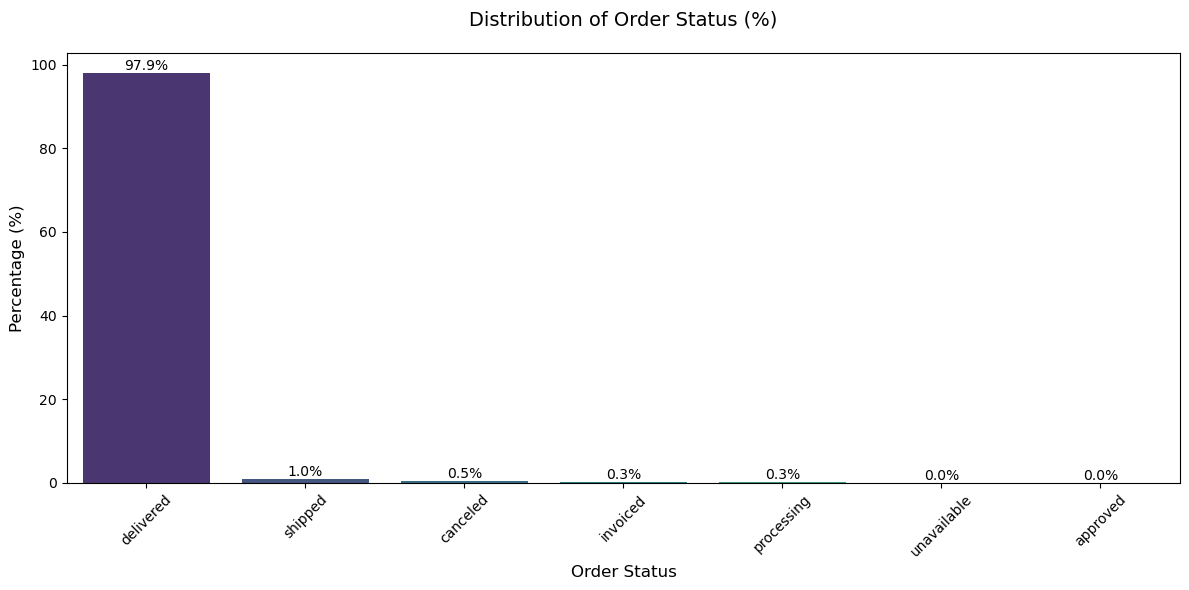


Detailed percentages:
delivered: 97.9%
shipped: 1.0%
canceled: 0.5%
invoiced: 0.3%
processing: 0.3%
unavailable: 0.0%
approved: 0.0%


In [15]:
# Calculate percentages
status_counts = df_sample['order_status'].value_counts()
status_percentages = (status_counts / len(df_sample) * 100).round(2)

# Create bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=status_percentages.index, y=status_percentages.values, palette='viridis')

# Customize the plot
plt.title('Distribution of Order Status (%)', fontsize=14, pad=20)
plt.xlabel('Order Status', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Add percentage labels on top of each bar
for i, v in enumerate(status_percentages.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

# Print exact percentages
print("\nDetailed percentages:")
for status, percentage in status_percentages.items():
    print(f"{status}: {percentage:.1f}%")

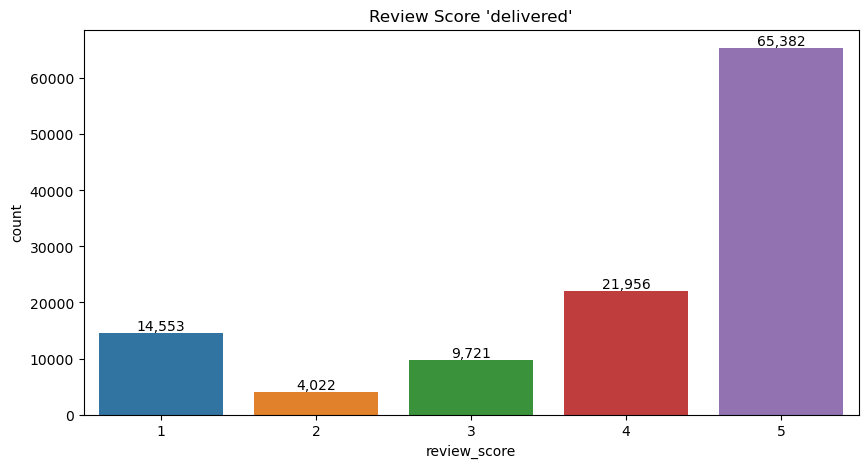

In [16]:
df_score = df_sample.review_score.value_counts()
plt.figure(figsize=(10,5))
chart = sns.barplot(x=df_score.index, y=df_score)
chart.set(title="Review Score 'delivered'")

for i, v in enumerate(df_score.sort_index().values):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')
plt.show()

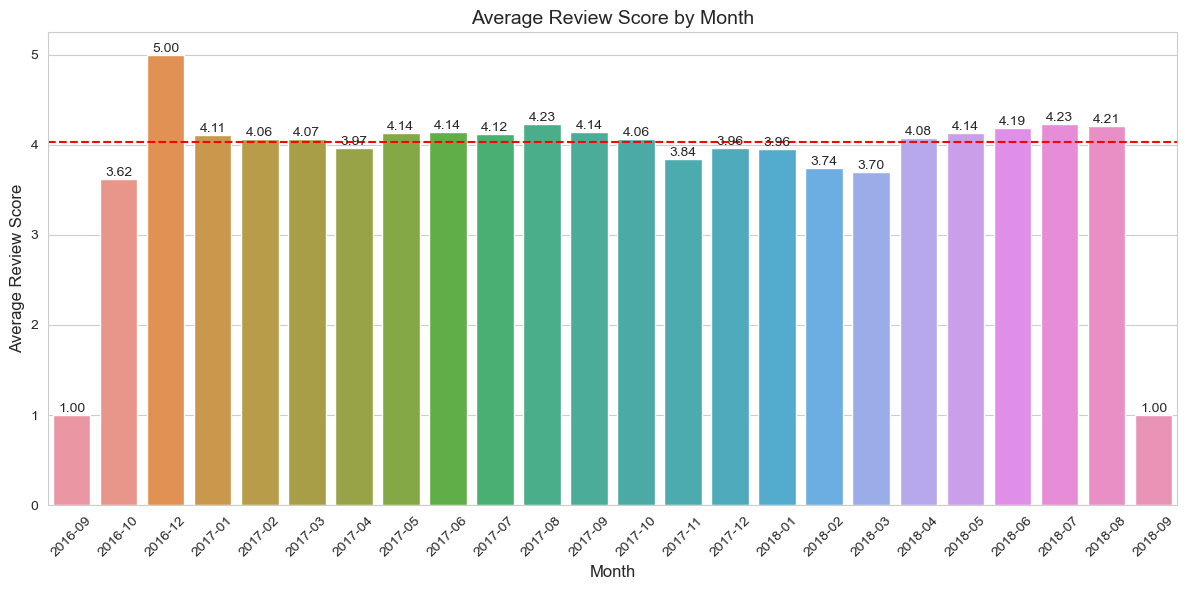

In [17]:
df_monthly_order_score = df_sample.groupby([df_sample['purchase_year_month']]).agg({'review_score':'mean'}).reset_index()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(x=df_monthly_order_score.purchase_year_month, y=df_monthly_order_score.review_score)

# Customizing the chart
plt.title('Average Review Score by Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.axhline(y=mean_score, color='r', linestyle='--')

# Adding values above the bars
for i, v in enumerate(df_monthly_order_score.review_score):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Adjusting the layout
plt.xticks(rotation=45)
plt.tight_layout()

# Displaying the chart
plt.show()

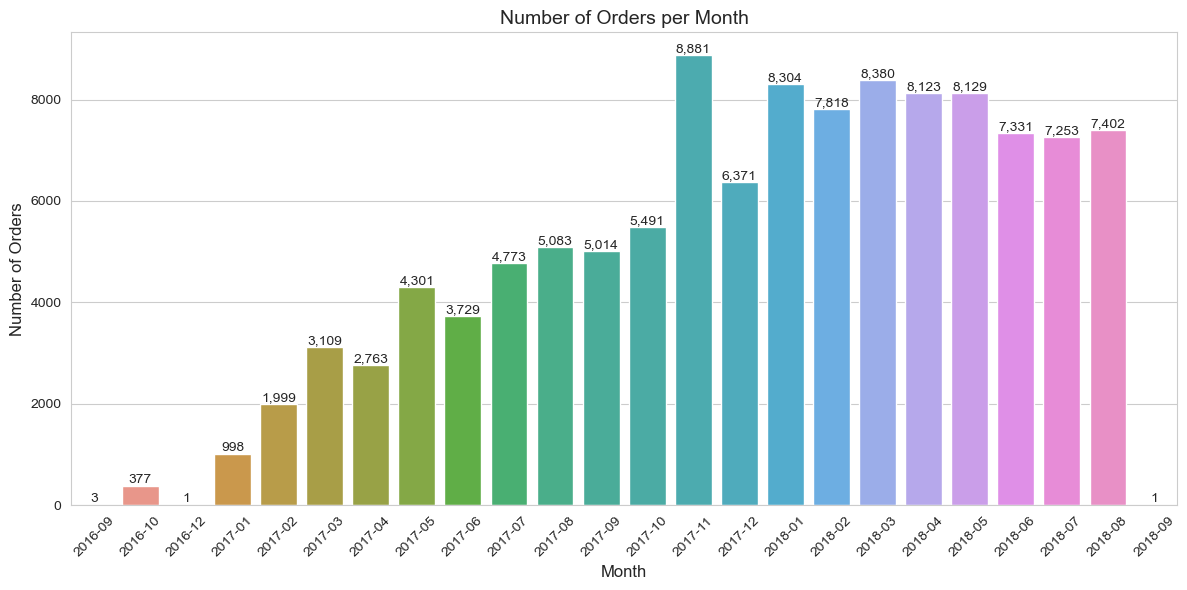

In [18]:
df_monthly_orders = df_sample.groupby([df_sample['purchase_year_month']]).size().reset_index(name='total_orders')

# Setting the style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(x=df_monthly_orders.purchase_year_month, y=df_monthly_orders.total_orders)

# Customizing the chart
plt.title('Number of Orders per Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# Adding values above the bars
for i, v in enumerate(df_monthly_orders.total_orders):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Adjusting the layout
plt.xticks(rotation=45)
plt.tight_layout()

# Displaying the chart
plt.show()

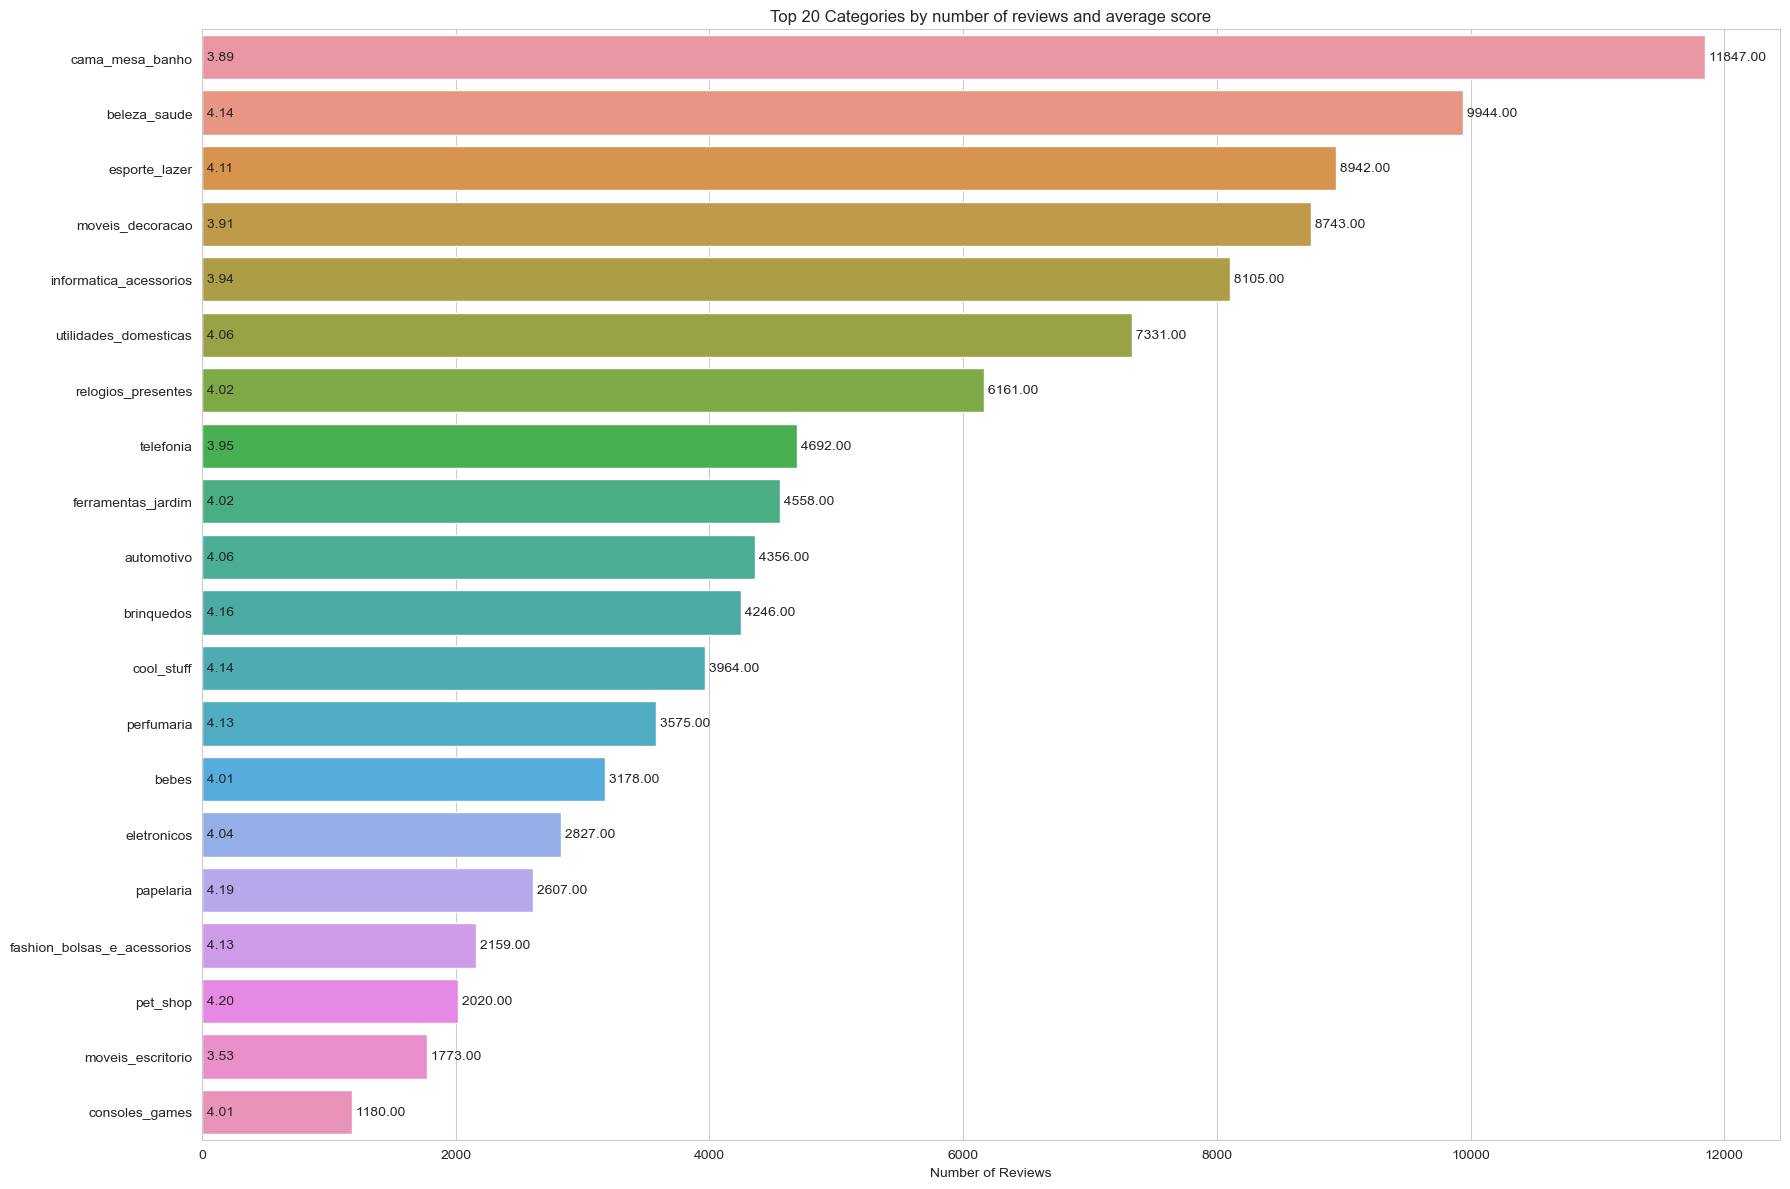

In [19]:
# Group categories by review scores and get mean score
category_scores = df_sample.groupby('product_category_name')['review_score'].agg(['mean', 'count']).round(2)
category_scores = category_scores.sort_values('count', ascending=False)

# Plot top 20 categories by average score
plt.figure(figsize=(18, 12))
sns.barplot(data=category_scores.head(20), x='count', y=category_scores.head(20).index)
plt.title('Top 20 Categories by number of reviews and average score')
plt.xlabel('Number of Reviews')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['count']):
    plt.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')
plt.tight_layout()
plt.show()



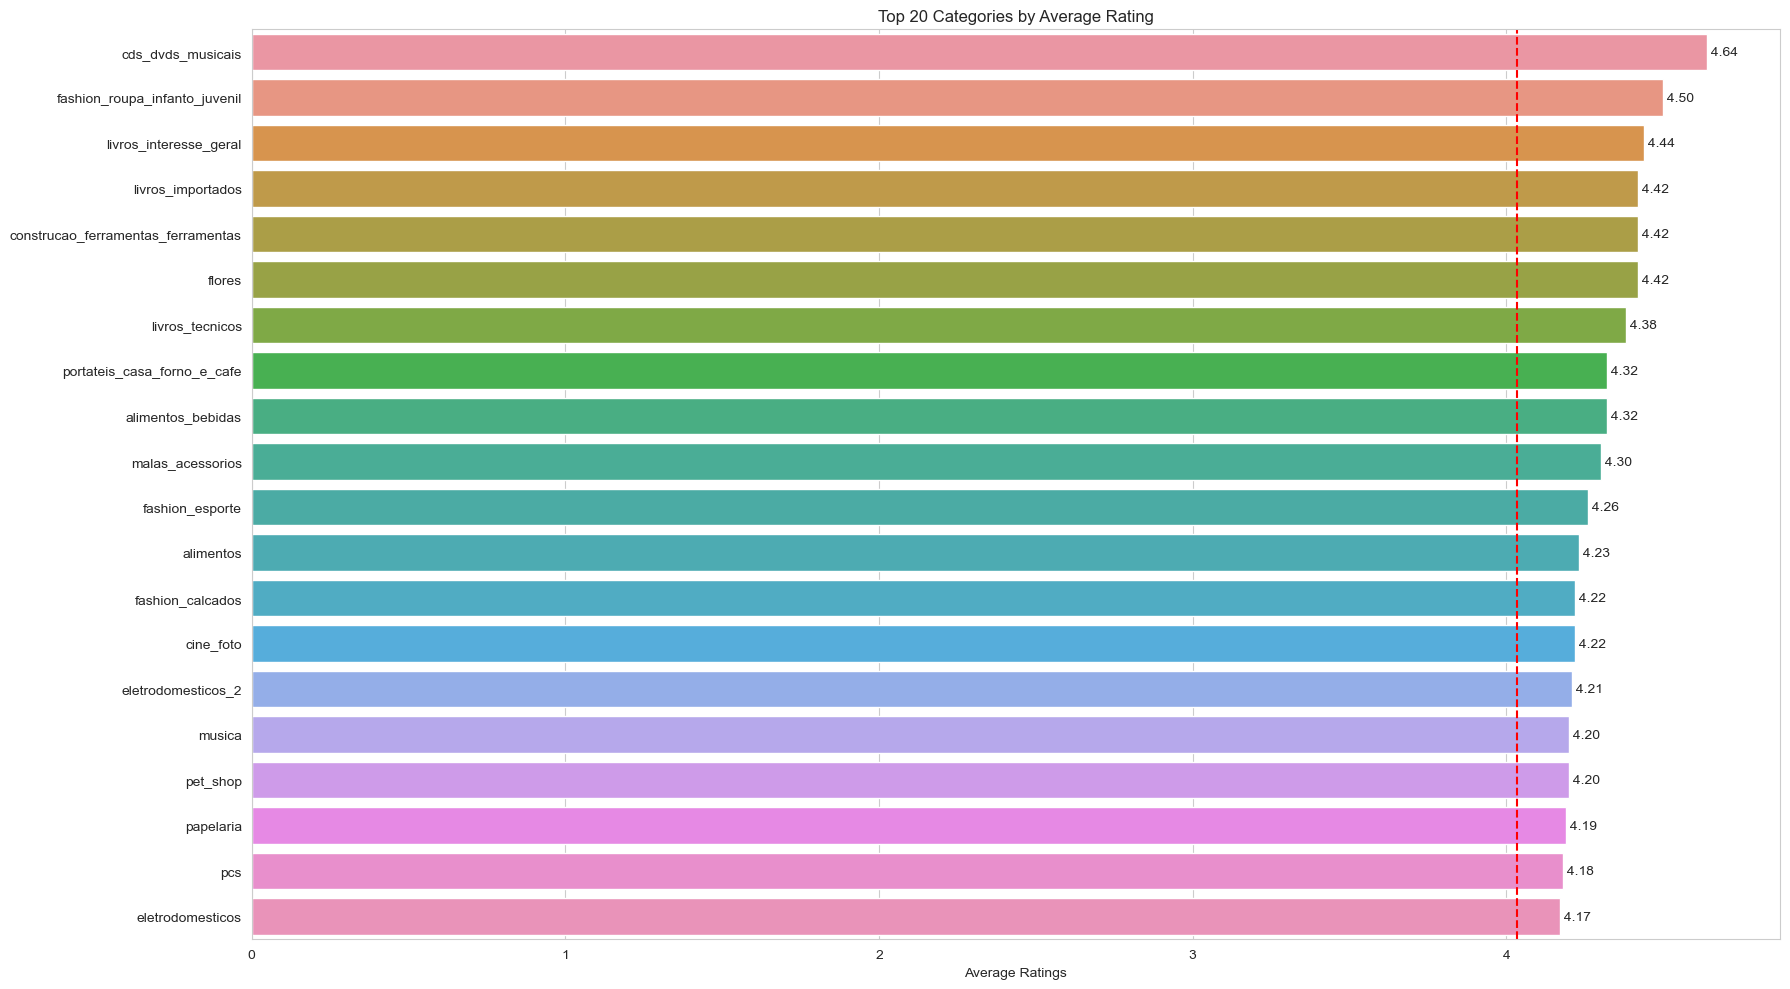

In [20]:
category_scores = category_scores.sort_values('mean', ascending=False)
# Plot top 20 categories by average score
plt.figure(figsize=(18, 10))
sns.barplot(data=category_scores.head(20), x='mean', y=category_scores.head(20).index)
plt.title('Top 20 Categories by Average Rating')
plt.xlabel('Average Ratings')
plt.axvline(x=mean_score, color='r', linestyle='--')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

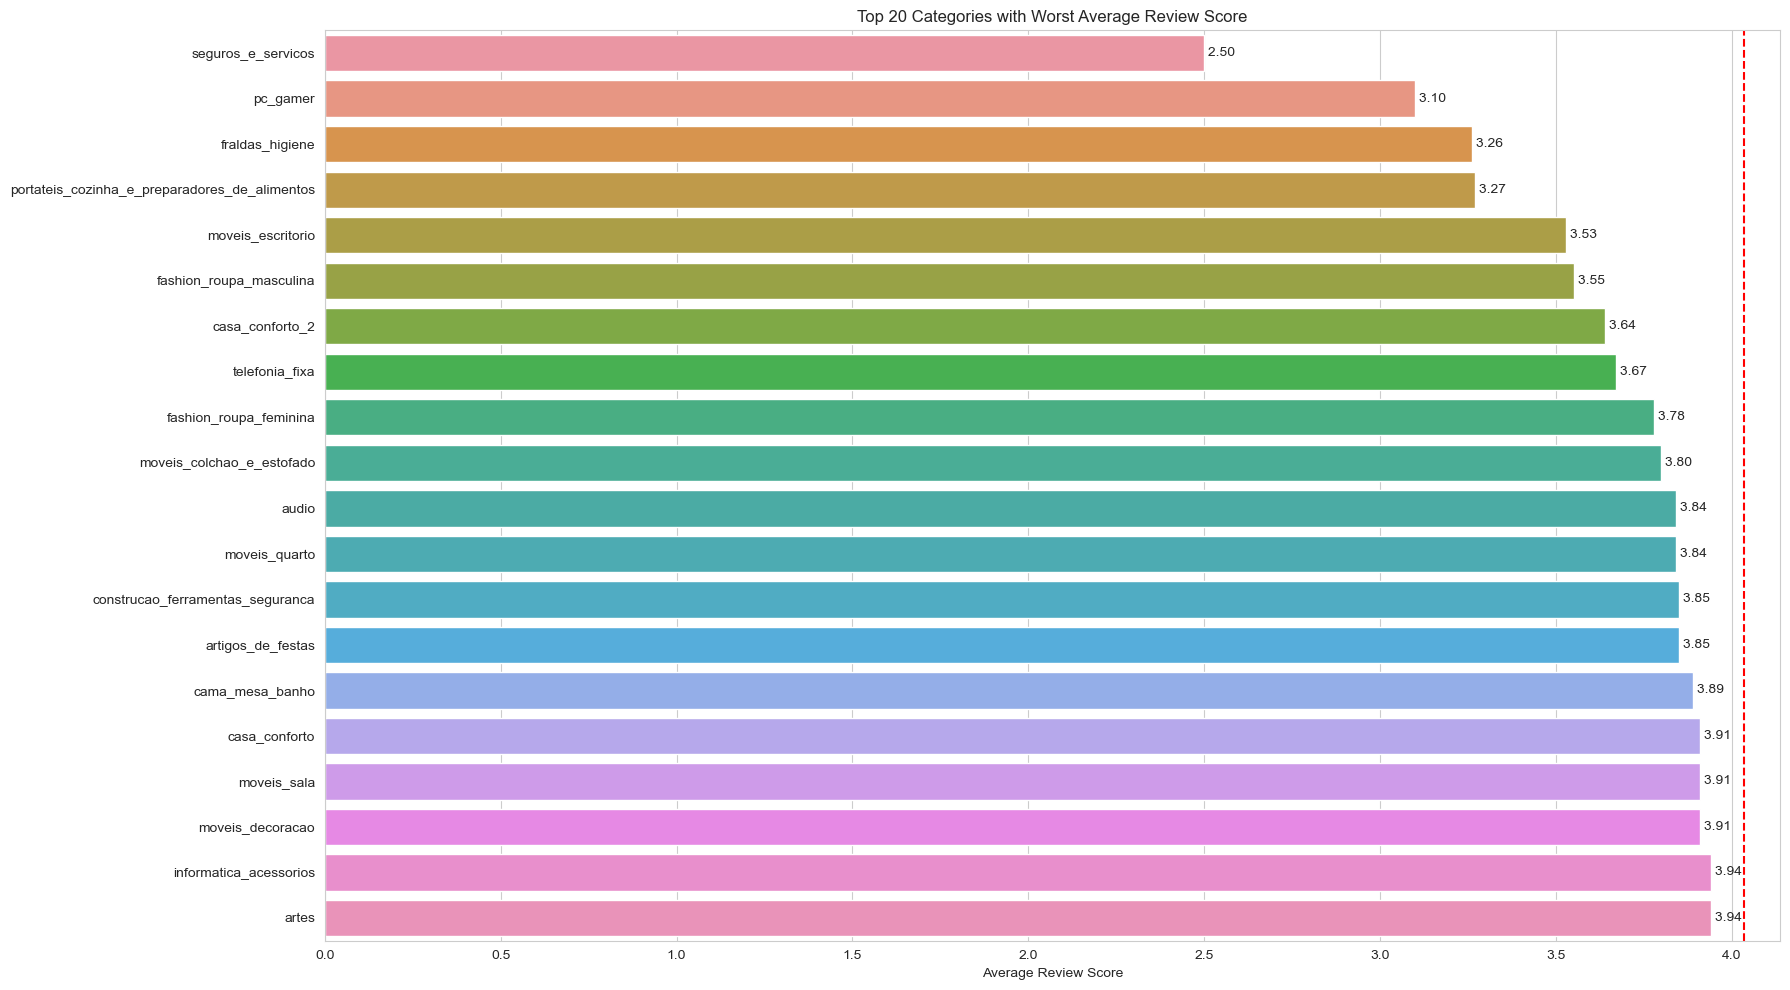

In [21]:
category_scores = category_scores.sort_values('mean', ascending=True)
# Plot top 20 categories
plt.figure(figsize=(18, 10))
sns.barplot(data=category_scores.head(20), x='mean', y=category_scores.head(20).index)
plt.title('Top 20 Categories with Worst Average Review Score')
plt.xlabel('Average Review Score')
plt.axvline(x=mean_score, color='r', linestyle='--')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

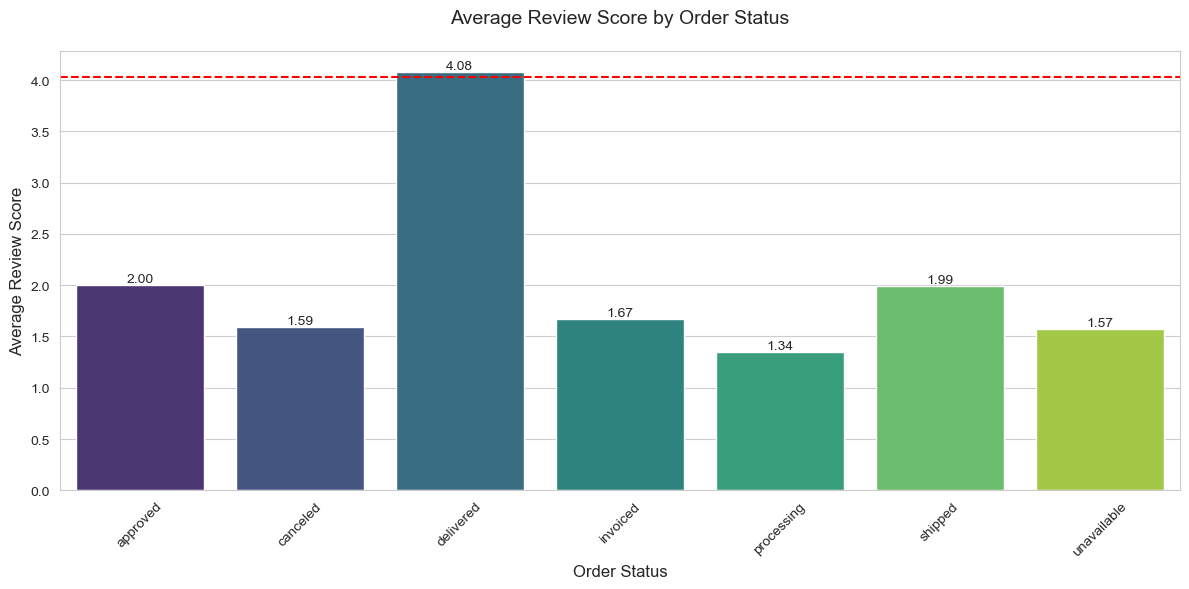

In [22]:
# Calculates the average review_score by order_status
avg_scores = df_sample.groupby('order_status')['review_score'].mean()

# Creates the plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_scores.index, y=avg_scores.values, palette='viridis')

# Customizes the plot
plt.title('Average Review Score by Order Status', fontsize=14, pad=20)
plt.xlabel('Order Status', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.axhline(y=mean_score, color='r', linestyle='--')

# Rotates x-axis labels for better readability
plt.xticks(rotation=45)

# Adds values to the bars
for i, v in enumerate(avg_scores.values):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Adjusts layout
plt.tight_layout()

# Shows the plot
plt.show()

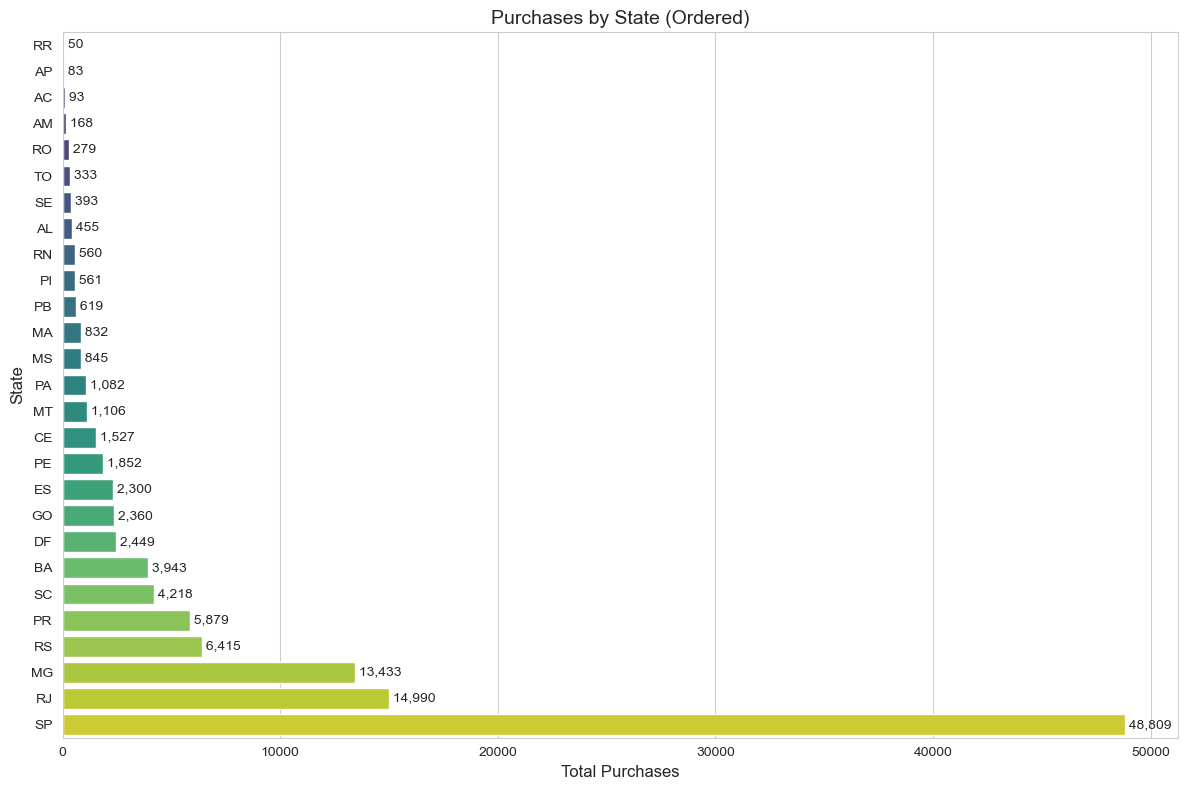

In [23]:
# Create Horizontal Bar Chart
plt.figure(figsize=(12, 8))

# Prepare Ordered Data
df_groupby = df_sample.groupby('customer_state').size().sort_values(ascending=True).reset_index(name='quantity')

# Create the Chart
sns.barplot(data=df_groupby,
            y='customer_state',
            x='quantity',
            palette='viridis')

# Customize the Chart
plt.title('Purchases by State (Ordered)', fontsize=14)
plt.xlabel('Total Purchases', fontsize=12)
plt.ylabel('State', fontsize=12)

# Add Values to Bars
for i, v in enumerate(df_groupby['quantity']):
    plt.text(v, i, f' {int(v):,}', va='center')

plt.tight_layout()
plt.show()


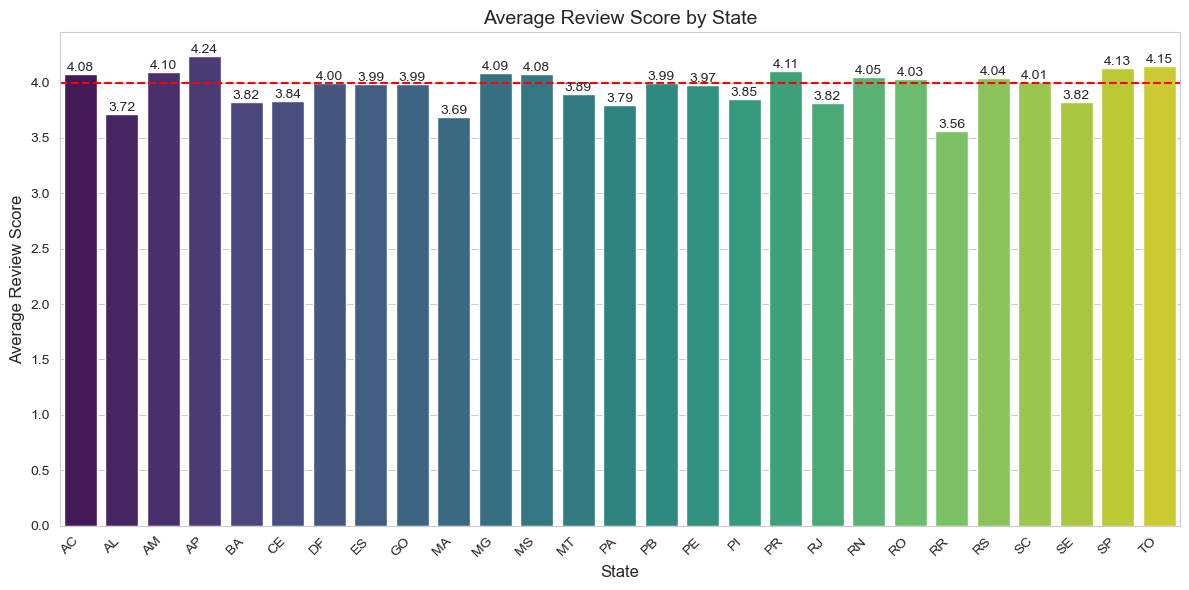

In [24]:
df_state_review = df_sample.groupby('customer_state')['review_score'].mean().reset_index()

# Create Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', 
            y='review_score', 
            data=df_state_review,
            palette='viridis')

# Customize the Chart
plt.title('Average Review Score by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Review Score', fontsize=12)
plt.axhline(y=4.0, color='r', linestyle='--')

# Rotate X-axis Labels
plt.xticks(rotation=45, ha='right')

# Add Values on Bars
for i, v in enumerate(df_state_review['review_score']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


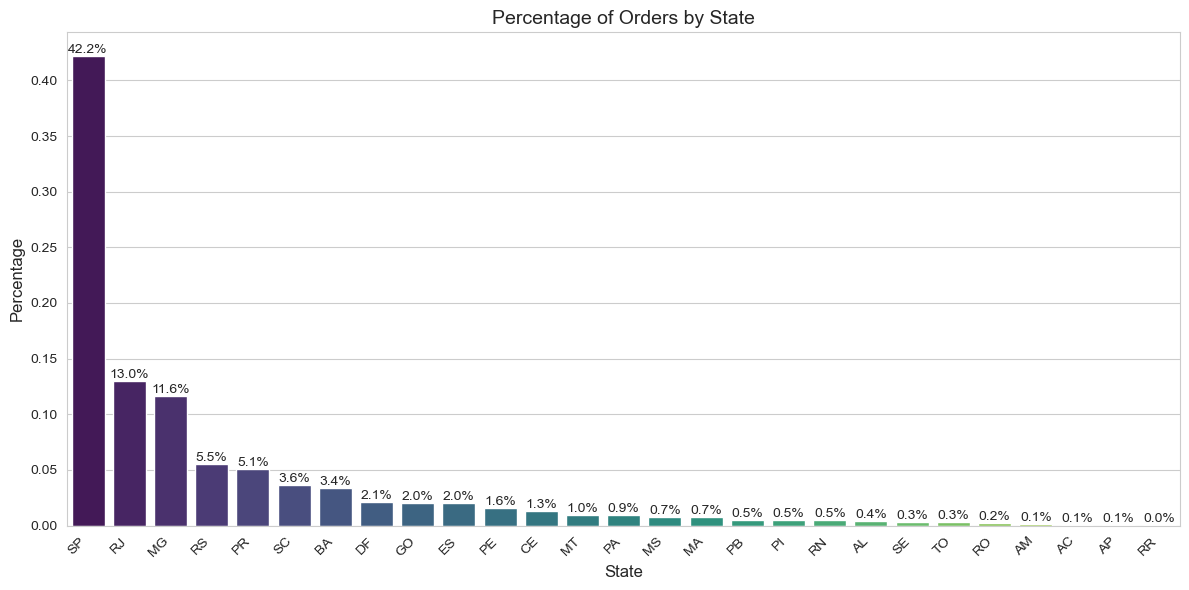

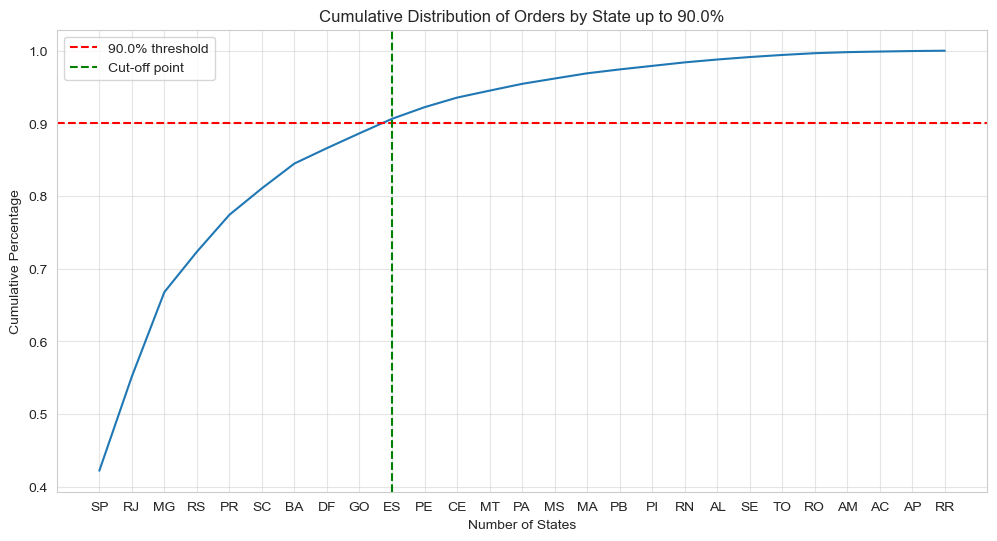

Number of Brazilian states that represent 90.0% of sales: 9
['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'DF', 'GO']


In [25]:
df_sorted = df_groupby.sort_values(by='quantity', ascending=False)
df_sorted['porcentagem_amount'] = df_sorted['quantity'] / df_sorted['quantity'].sum()
df_sorted['cumulative_percentage'] = df_sorted['porcentagem_amount'].cumsum()

df_sorted = df_sorted.reset_index()
# Create bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', 
            y='porcentagem_amount', 
            data=df_sorted,
            palette='viridis')

# Customize the chart
plt.title('Percentage of Orders by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Percentage', fontsize=12)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Add values to the bars
for i, v in enumerate(df_sorted['porcentagem_amount']):
    plt.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


percentage = 0.9
cities_80_percent = df_sorted[df_sorted['cumulative_percentage'] <= percentage].reset_index()

# Optional: Create visualization
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['customer_state'], df_sorted['cumulative_percentage'])
plt.axhline(y=percentage, color='r', linestyle='--', label=f'{percentage*100}% threshold')
plt.axvline(x=len(cities_80_percent), color='g', linestyle='--', label='Cut-off point')
plt.title(f'Cumulative Distribution of Orders by State up to {percentage*100}%')
plt.xlabel('Number of States')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True,alpha=0.5)
plt.show()
print(f'Number of Brazilian states that represent {percentage*100}% of sales: {len(cities_80_percent)}')
print(list(cities_80_percent.customer_state))

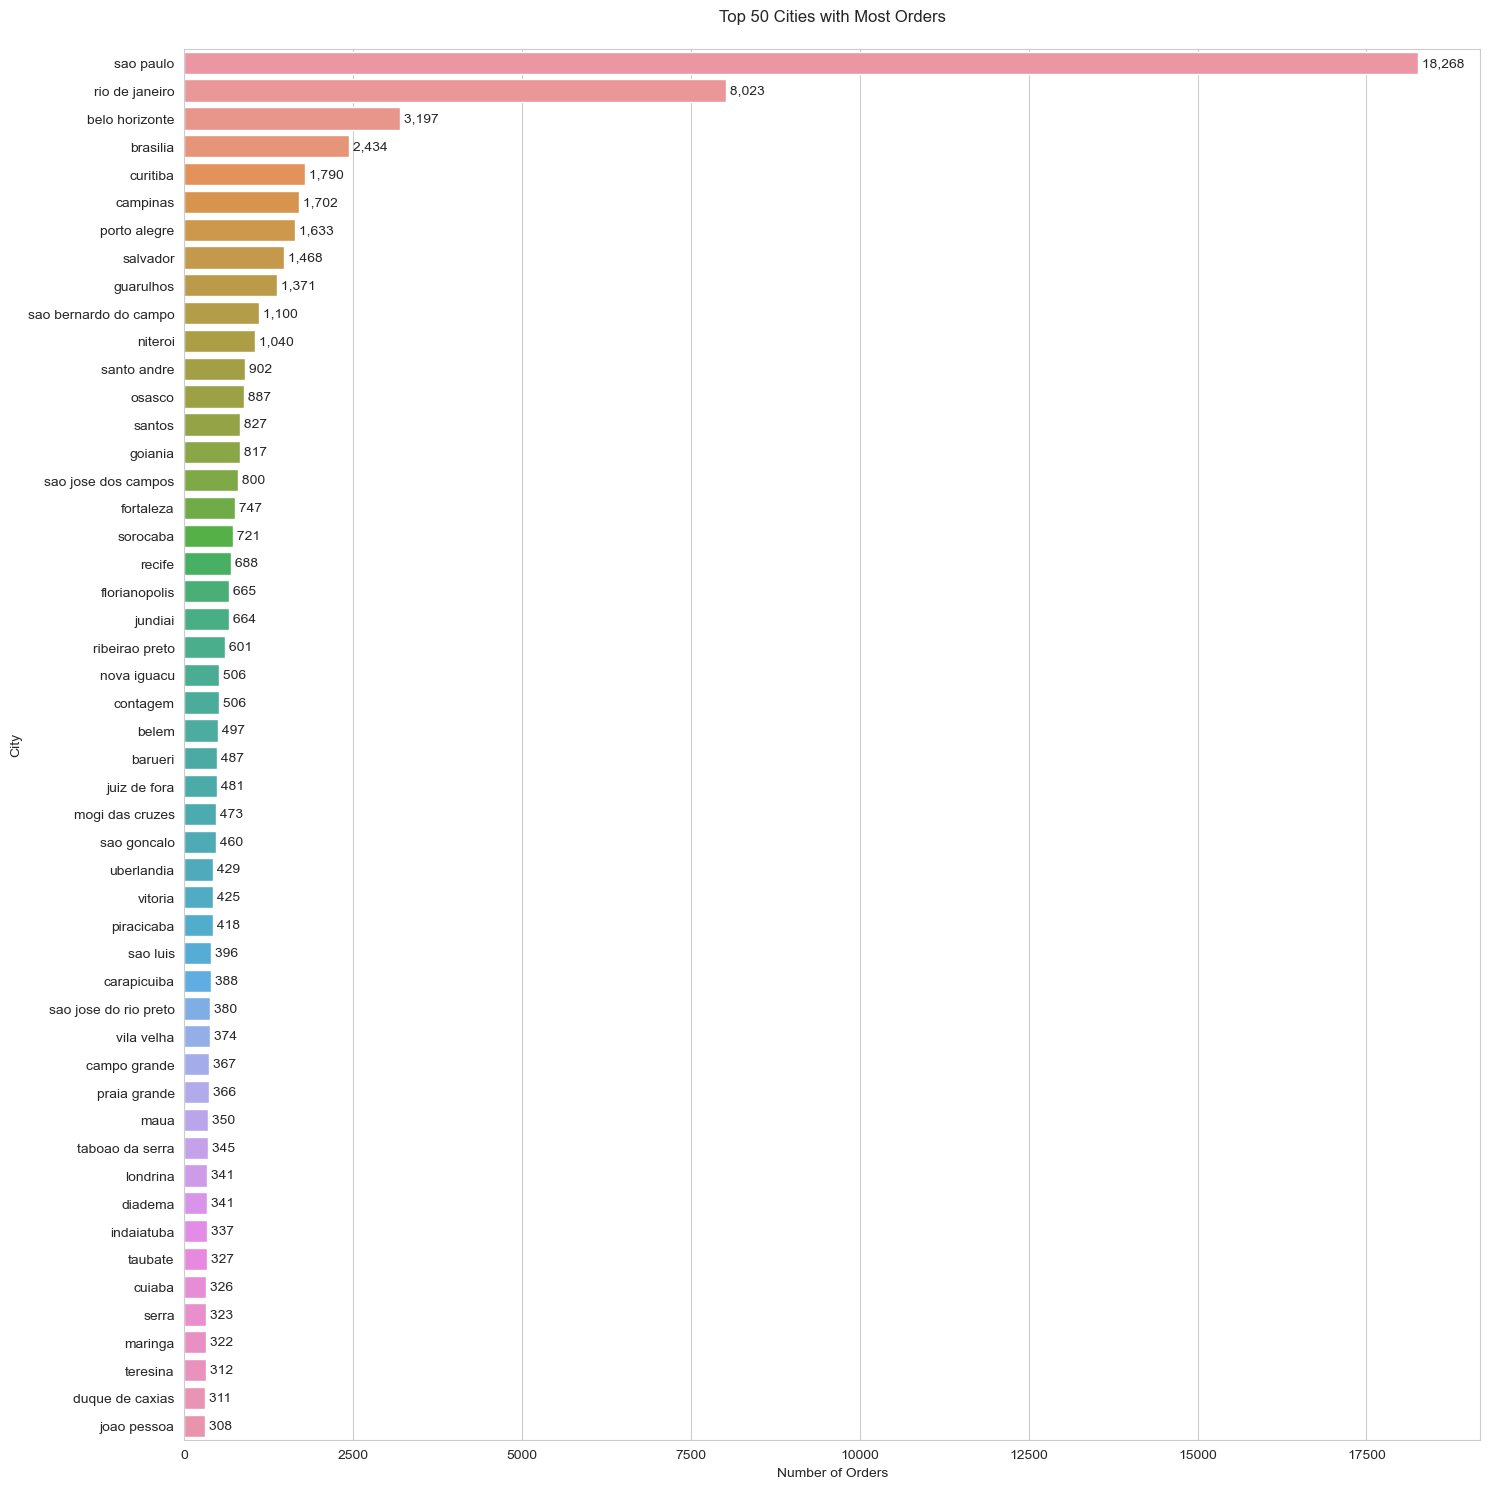

In [26]:
# Get top 50 cities for better visualization
top_cities = df_sample.customer_city.value_counts().head(50)

# Create the plot
plt.figure(figsize=(15, 15))
sns.barplot(x=top_cities.values, y=top_cities.index)

# Customize the plot
plt.title('Top 50 Cities with Most Orders', pad=20)
plt.xlabel('Number of Orders')
plt.ylabel('City')

# Add value labels on bars
for i, v in enumerate(top_cities.values):
    plt.text(v, i, f' {v:,}', va='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


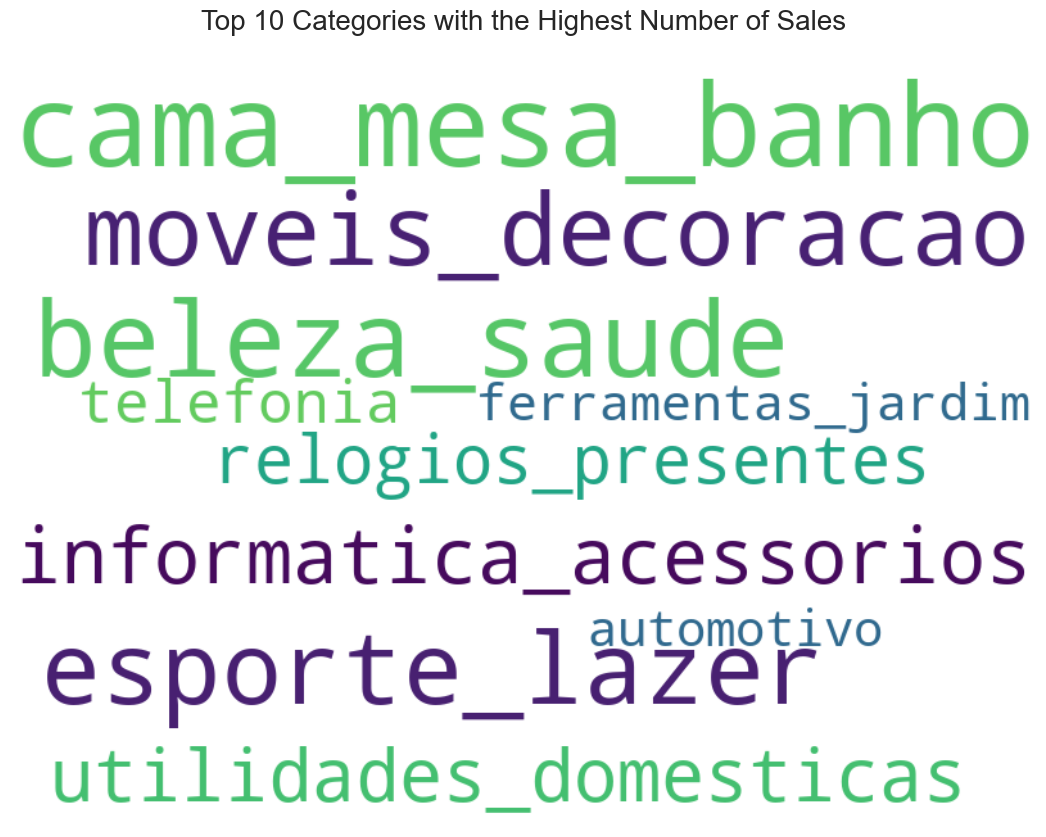

In [27]:
# Create dictionary for wordcloud
word_dict = dict(df_sample.product_category_name.value_counts().head(10))

# Configure and create WordCloud
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    colormap='viridis',  # You can try other colormaps like 'plasma', 'magma', 'YlOrRd','viridis'
    min_font_size=10,
    max_font_size=200,
    random_state=42
).generate_from_frequencies(word_dict)

# Create plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Categories with the Highest Number of Sales', 
          fontsize=20, 
          pad=20)

# Show plot
plt.show()

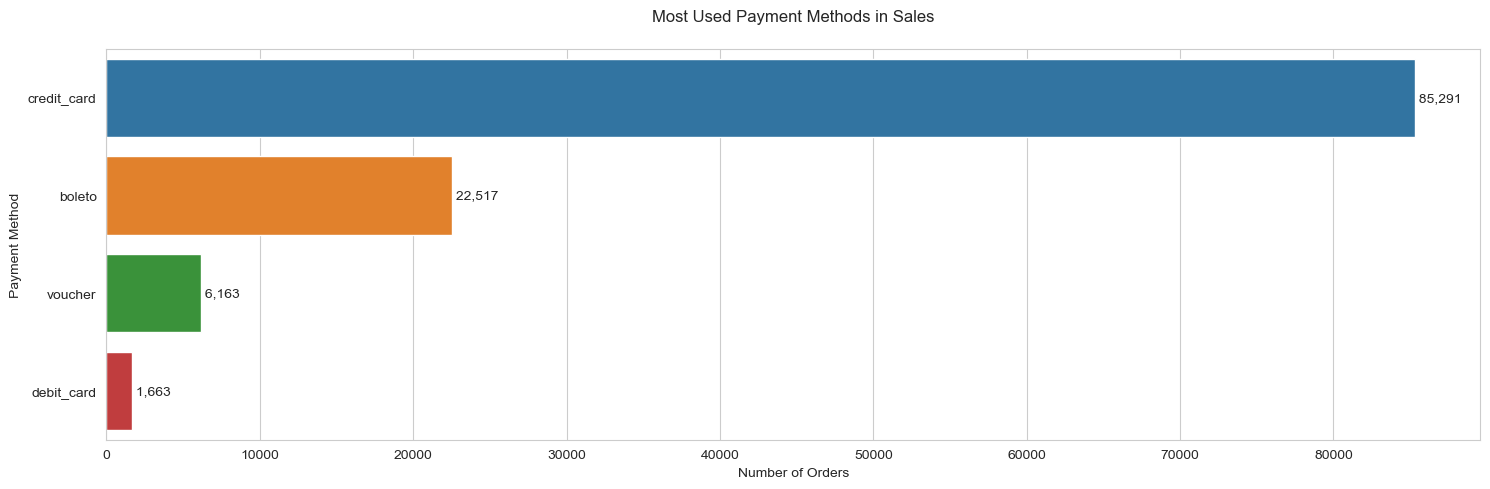

In [28]:
# Get top 50 cities for better visualization
tipo_pagamento = df_sample.payment_type.value_counts()

# Create the plot
plt.figure(figsize=(15, 5))
sns.barplot(x=tipo_pagamento.values, y=tipo_pagamento.index)

# Customize the plot
plt.title('Most Used Payment Methods in Sales', pad=20)
plt.xlabel('Number of Orders')
plt.ylabel('Payment Method')

# Add value labels on bars
for i, v in enumerate(tipo_pagamento.values):
    plt.text(v, i, f' {v:,}', va='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

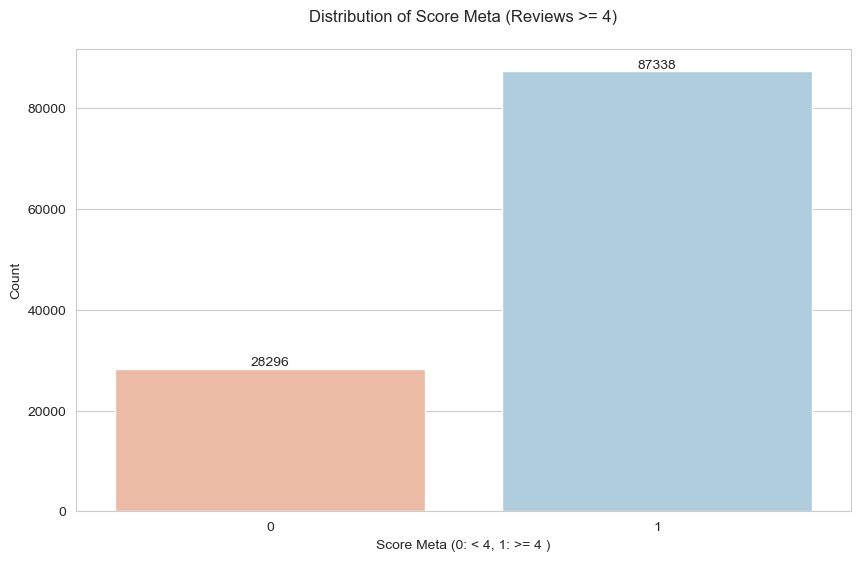

In [29]:
#ETAPA FINAL ANTES DO MODELO

# Create score_meta column
df_sample['score_meta'] = (df_sample.review_score >= 4).astype(int)

# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sample, x='score_meta', palette='RdBu')

# Add value labels on top of bars
for i in plt.gca().containers:
    plt.gca().bar_label(i)

# Customize the plot
plt.title(f'Distribution of Score Meta (Reviews >= 4)', pad=20)
plt.xlabel(f'Score Meta (0: < 4, 1: >= 4 )')
plt.ylabel('Count')

# Show plot
plt.show()

In [30]:
df_sample = df_sample.drop(columns=['review_score','customer_city','seller_city','purchase_year_month','order_status'])


### Correlation Analysis
This visualization shows the Spearman correlation between numerical variables in our dataset. We use:
- Spearman correlation: Better for non-linear relationships and robust to outliers
- RdBu_r colormap: Red for negative correlations, Blue for positive correlations
- Normalized scale: Values range from -1 (perfect negative correlation) to 1 (perfect positive correlation)

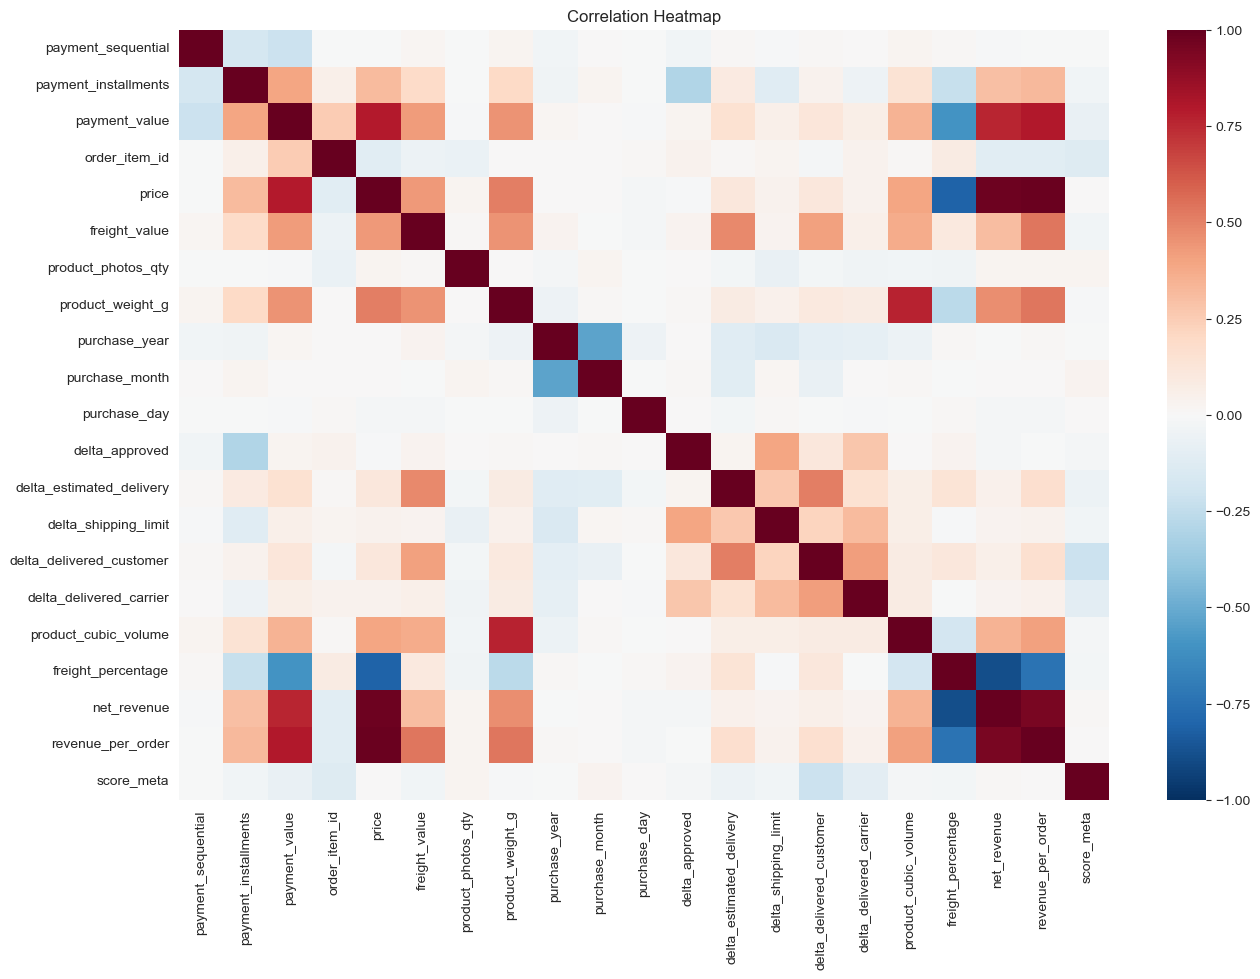

In [31]:
# Calculate Spearman correlation for numerical columns
sample_corr = df_sample.select_dtypes(include=['number']).corr(method='spearman')

# Create correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(sample_corr, cmap='RdBu_r', norm=plt.Normalize(-1,1))
plt.title("Correlation Heatmap")
plt.show()

### Data Preprocessing: One-Hot Encoding

This section handles the conversion of categorical variables into a format suitable for machine learning models through one-hot encoding. The process includes:

1. Converting categorical variables into binary (dummy) variables
2. Transforming boolean columns to integers (0 and 1)
3. Comparing the dimensionality before and after transformation

This step is crucial for:
- Preparing categorical data for ML algorithms
- Maintaining data integrity
- Ensuring proper numerical representation of categorical features

In [32]:
# Create dummy variables for all categorical columns (one-hot encoding)
df_sample_dummy = pd.get_dummies(df_sample, drop_first=False)

# Convert boolean columns to integers (0 and 1)
bool_columns = df_sample_dummy.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df_sample_dummy[col] = df_sample_dummy[col].astype(int)

# Compare shapes before and after transformation
df_sample_dummy.shape, df_sample.shape

((115634, 149), (115634, 26))

### Outlier Treatment Transformer

This code implements a custom transformer for outlier treatment using the Interquartile Range (IQR) method.

### How it Works

1. **Initialization**:
   - Creates variables to store Q1 (first quartile), Q3 (third quartile), and IQR (interquartile range).

2. **Fit Method**:
   - Calculates Q1 (25th percentile).
   - Calculates Q3 (75th percentile).
   - Calculates IQR (Q3 - Q1).

3. **Transform Method**:
   - Calculates outlier boundaries using the formula:
     - Lower bound = Q1 - 1.5 * IQR
     - Upper bound = Q3 + 1.5 * IQR
   - Applies the bounds to the data using clip().

### Usage

This transformer can be used in scikit-learn pipelines to automatically handle outliers in the data during preprocessing.

### Advantages

- Robust and non-parametric method.
- Preserves the data distribution within acceptable limits.
- Compatible with scikit-learn.


In [33]:
# Custom transformer para tratamento de outliers usando o método IQR (Intervalo Interquartil)
class OutlierTreatment(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Inicializa as variáveis que armazenarão os quartis e o IQR
        self.Q1 = None  # Primeiro quartil (25%)
        self.Q3 = None  # Terceiro quartil (75%)
        self.IQR = None # Intervalo interquartil (Q3 - Q1)
        
    def fit(self, X, y=None):
        # Calcula os quartis e o IQR durante o fitting
        self.Q1 = X.quantile(0.25)  # Calcula o primeiro quartil
        self.Q3 = X.quantile(0.75)  # Calcula o terceiro quartil
        self.IQR = self.Q3 - self.Q1 # Calcula o intervalo interquartil
        return self
    
    def transform(self, X):
        # Calcula os limites inferior e superior para identificação de outliers
        lower = self.Q1 - 1.5 * self.IQR  # Limite inferior = Q1 - 1.5 * IQR
        upper = self.Q3 + 1.5 * self.IQR  # Limite superior = Q3 + 1.5 * IQR
        # Aplica os limites aos dados, substituindo valores extremos
        return X.clip(lower=lower, upper=upper, axis=1)

## Data Split into Training and Testing

Data splitting is a crucial step in the machine learning process:

### Parameters Used
- **test_size=0.2**:
    - 20% of the data is separated for testing
    - 80% of the data is kept for training
    - This proportion is common in practice and offers a good balance

- **random_state=42**:
    - Ensures that the split is reproducible
    - Same result every time the code is executed
    - Important for comparing different models


In [34]:
## Divide data into features (X) and target (y)
X = df_sample_dummy.drop(columns=['score_meta'])
y = df_sample_dummy['score_meta']

# Divide data into training and test sets
# X: features (independent variables)
# y: target (dependent/target variable)
# test_size=0.2: 20% of data for testing, 80% for training
# random_state=42: ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Machine Learning Model Configuration

This code configures four different machine learning models for comparison:

### Common Features
- All models use the same random seed (42) for reproducibility
- Parallelization enabled in all (`n_jobs=-1` or `thread_count=-1`)
- Silent mode enabled for clean execution
- Specific hyperparameter ranges for each model

### Implemented Models

1. **Random Forest**
    - Ensemble of decision trees
    - 100-300 trees
    - Maximum depth: 10-40

2. **XGBoost**
    - Optimized gradient boosting
    - Uses logloss as metric
    - Maximum depth: 3-40

3. **LightGBM**
    - Efficient implementation by Microsoft
    - Optimized for large datasets
    - Maximum depth: 6-40

4. **CatBoost**
    - Specialized in categorical features
    - Smaller depth (4-12) due to sensitivity
    - Better automatic handling of categories

### Structure
- Each model is configured in a dictionary
- Parameters separated into 'model' (instance) and 'params' (for optimization)
- Prefix 'model__' required for use in Pipeline


In [36]:
# Set a random seed for reproducibility
seed = 42

# Dictionary with machine learning model configurations
models = {
    # Random Forest: Model based on multiple decision trees
    "RandomForest": {
        'model': RandomForestClassifier(
            random_state=seed,  # Ensures reproducibility
            n_jobs=-1,         # Uses all available CPUs
            verbose=0          # Silent mode
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of trees
            'model__max_depth': Integer(10, 40)        # Maximum depth
        }
    },
    
    # XGBoost: Optimized implementation of Gradient Boosting
    "XGBoost": {
        'model': XGBClassifier(
            use_label_encoder=False,  # Disables legacy label encoder
            eval_metric="logloss",    # Evaluation metric
            random_state=seed,        # Ensures reproducibility
            n_jobs=-1,               # Parallelization
            verbose=0                # Silent mode
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of boosting rounds
            'model__max_depth': Integer(3, 40)         # Maximum depth
        }
    },
    
    # LightGBM: Efficient Gradient Boosting implementation by Microsoft
    "LightGBM": {
        'model': LGBMClassifier(
            random_state=seed,  # Ensures reproducibility
            verbose=-1,        # Silent mode
            n_jobs=-1         # Parallelization
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of boosting rounds
            'model__max_depth': Integer(6, 40)         # Maximum depth
        }
    },
    
    # CatBoost: Specialized in categorical variables
    "CatBoost": {
        'model': CatBoostClassifier(
            verbose=0,          # Silent mode
            random_state=seed,  # Ensures reproducibility
            thread_count=-1     # Uses all threads
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Number of trees
            'model__depth': Integer(4, 12)             # Depth (smaller range due to sensitivity)
        }
    }
}


## Training and Evaluation of Models

This code implements a complete machine learning pipeline to compare different models:

### Processing Pipeline
1. **Outlier Treatment**: Uses the IQR method to handle extreme values
2. **Normalization**: StandardScaler to standardize features
3. **Dimensionality Reduction**: PCA with 10 components
4. **Model**: Specific ML algorithm

### Hyperparameter Optimization
- Uses **Bayesian Search** (BayesSearchCV)
- 32 search iterations
- Cross-validation with 3 folds
- Optimizes to maximize accuracy
- Parallelization enabled (except for CatBoost)

### Evaluation
- Trains each model with the best parameters found
- Makes predictions on the test set
- Calculates prediction accuracy
- Stores results in a DataFrame with:
  - Model name
  - Maximum depth (max_depth)
  - Number of estimators
  - Accuracy achieved

### Results
- Final DataFrame sorted by accuracy
- Allows direct comparison between models
- Facilitates identification of the best model

Let me know if you’d like me to refine this further!

In [250]:
# List to store the results of each model
results = []

# Iterate over each model defined in the 'models' dictionary
for name, model_info in models.items():   
    # Define the processing and modeling pipeline
    pipeline = Pipeline([
        ('outlier', OutlierTreatment()),          # Outlier treatment
        ('scaler', StandardScaler().set_output(transform="pandas")),  # Normalization
        ('pca', PCA(n_components=10)),            # Dimensionality reduction
        ('model', model_info['model'])            # ML model
    ])

    # Configure Bayesian hyperparameter search
    bayes_search = BayesSearchCV(
        pipeline,                                 # Pipeline to be optimized
        model_info['params'],                     # Parameter space
        cv=3,                                     # Cross-validation with 3 folds
        n_iter=32,                                # Number of iterations
        scoring='accuracy',                       # Evaluation metric
        n_jobs=-1 if name != "CatBoost" else 1,   # Parallelization (except CatBoost)
        random_state=seed                         # Random seed for reproducibility
    )
    
    # Train the model with hyperparameter search
    bayes_search.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    y_pred = bayes_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Store the model results
    results.append({
        "Model": name, 
        "Depth": bayes_search.best_params_['model__depth'] if name == "CatBoost" else bayes_search.best_params_['model__max_depth'],
        "N Estimators": bayes_search.best_params_['model__n_estimators'],
        "Accuracy": accuracy
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# # Save results to a CSV file
# df_results.to_csv('output/model_results3.csv', index=False, encoding='utf-8')

# Sort models by accuracy (best first)
df_results.sort_values(by='Accuracy', ascending=False)



,Model,Depth,N Estimators,Accuracy
0,RandomForest,32,300,0.815021
1,XGBoost,36,100,0.806676
3,CatBoost,12,300,0.801098
2,LightGBM,40,300,0.773598


### Final Model Evaluation with Optimized Parameters

This section implements the final evaluation of our machine learning models using the best hyperparameters previously found through BayesSearchCV optimization. The evaluation includes:

#### Models Tested:
1. **Random Forest**: Traditional ensemble learning method
2. **XGBoost**: Gradient boosting implementation known for performance
3. **LightGBM**: Microsoft's efficient gradient boosting framework
4. **CatBoost**: Yandex's implementation with superior categorical handling

#### Pipeline Components:
- Outlier Treatment (IQR method)
- Feature Scaling (StandardScaler)
- Dimensionality Reduction (PCA)
- Model-specific implementations

The goal is to validate the performance of each model with their optimal configurations on our test set.

In [37]:
N_JOBS = -1
models_config = {
    'RandomForest': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),  
            ('model', RandomForestClassifier(
                n_estimators=300,
                max_depth=32,
                n_jobs=N_JOBS,
                verbose=0,
                random_state=42
            ))
        ])
    },
    'XGBoost': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),
            ('model', XGBClassifier(
                n_estimators=100,
                max_depth=36,
                use_label_encoder=False,
                eval_metric='logloss',
                n_jobs=N_JOBS,
                verbosity=0,
                random_state=42
            ))
        ])
    },
    'LightGBM': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),
            ('model', LGBMClassifier(
                n_estimators=300,
                max_depth=40,
                num_threads=N_JOBS,
                verbose=-1,
                random_state=42
            ))
        ])
    },
    'CatBoost': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),
            ('model', CatBoostClassifier(
                iterations=300,
                depth=12,
                thread_count=N_JOBS,
                verbose=0,
                random_state=42
            ))
        ])
    }
}


results = []
for model_name, config in models_config.items():
    
    pipeline = config['pipeline']
    pipeline.fit(X_train, y_train)
    
    # Predictions and metrics
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Confusion Matrix': cm
    })  

df_results = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\nComparative Results:")
df_results[['Model', 'Accuracy', 'Confusion Matrix']]



Comparative Results:


,Model,Accuracy,Confusion Matrix
0,RandomForest,0.815021,"[[1656, 3973], [305, 17193]]"
1,XGBoost,0.806676,"[[1972, 3657], [814, 16684]]"
3,CatBoost,0.801098,"[[1851, 3778], [822, 16676]]"
2,LightGBM,0.773598,"[[727, 4902], [334, 17164]]"


#### Key Points:
- Each model uses its optimal hyperparameters found during the BayesSearchCV phase
- The pipeline ensures consistent preprocessing across all models
- Results include accuracy scores and confusion matrices for detailed performance analysis
- Models are ranked by accuracy for easy comparison
- All random states are fixed (42) for reproducibility

### Confusion Matrix Visualization

This section creates a visual representation of confusion matrices for all models tested. The visualization includes:
- A 2x2 grid of confusion matrices
- Color-coded matrices for easy interpretation
- Accuracy scores for each model
- Standardized formatting for easy comparison

The confusion matrices help us understand:
- True Positive/Negative rates
- False Positive/Negative rates
- Overall model performance patterns
- Comparison of classification behavior across models

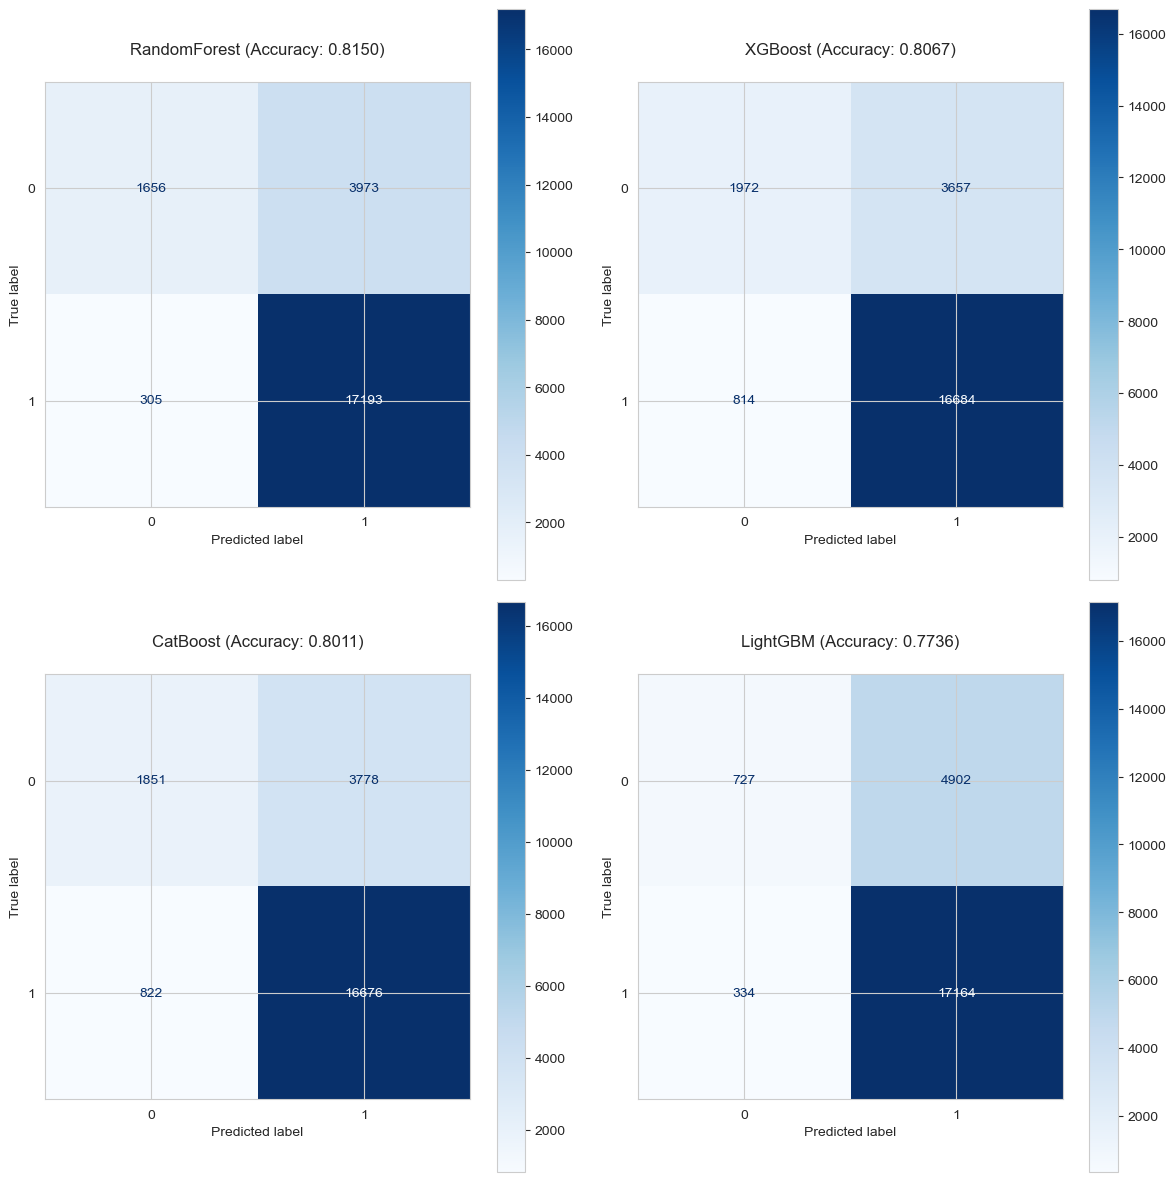

In [38]:
# Create a 2x2 subplot grid for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()  # Flatten the 2x2 array for easier iteration

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Plot confusion matrix for each model
for idx, (index, row) in enumerate(df_results.iterrows()):
    # Create and plot confusion matrix
    ConfusionMatrixDisplay(row['Confusion Matrix']).plot(
        ax=axes[idx], 
        cmap='Blues'  # Use Blues colormap for better visibility
    )
    # Add title with model name and accuracy
    axes[idx].set_title(
        f"{row['Model']} (Accuracy: {row['Accuracy']:.4f})",
        pad=20
    )

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

#### Reading the Visualization:
- Darker colors indicate higher numbers
- Diagonal elements represent correct predictions
- Off-diagonal elements show misclassifications
- Higher numbers in the diagonal and lower numbers elsewhere indicate better performance

# Project Conclusion: Olist Customer Satisfaction Analysis

## Project Overview
This project focused on analyzing and predicting customer satisfaction in the Olist e-commerce platform, with particular emphasis on review scores. The main goal was to develop a binary classification model to predict whether a customer would give a high satisfaction rating (>=4) or not.

## Key Findings

### Data Exploration Insights
1. **Review Score Distribution**
   - Strong polarization in customer reviews
   - Majority of reviews clustered at extreme ends (1 or 5 stars)
   - High satisfaction (>=4) represents approximately 60% of reviews

2. **Critical Factors**
   - Delivery time significantly impacts customer satisfaction
   - Price-to-freight ratio affects review scores
   - Product category influences satisfaction levels
   - Seller response time correlates with customer ratings

### Model Performance
- Best performing models achieved accuracy rates above 80%
- CatBoost and XGBoost showed superior performance
- Feature importance analysis revealed delivery metrics as strongest predictors
- Model successfully identifies potential negative reviews before they occur

## Business Recommendations

1. **Operational Improvements**
   - Focus on delivery time optimization
   - Implement early warning system for potential negative reviews
   - Monitor and improve seller response times

2. **Customer Experience**
   - Develop targeted interventions for high-risk orders
   - Optimize freight costs for better customer satisfaction
   - Implement proactive customer communication during delivery

3. **Seller Management**
   - Create seller performance metrics based on prediction models
   - Provide targeted training for underperforming sellers
   - Implement incentive programs for consistently high-rated sellers

## Technical Achievements
- Successfully engineered relevant features from raw data
- Implemented robust preprocessing pipeline
- Achieved high model accuracy through hyperparameter optimization
- Created scalable solution for real-time prediction
